In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

#creating fake observed data##########################################################################################
N = 1000 #no. stars in population

M_mu_actual = 1.0 #actual mean mass of population
M_sigma_actual = 0.1 #actual mass standard deviation of population
M_sigma_obs = 0.05 #observational uncertainty on mass.
 
#K_mu_actual = dependent on M through: N(−1.61+((𝑀−1)*0.2),0.03)
K_sigma_actual = 0.03 #actual K-band magntiude standard deviation of population
K_sigma_obs = 0.1 #observational uncertainty on K-band magnitude
K_mu_alpha_actual = -1.61 #variable that describes K_mu_actual
K_mu_beta_actual = 0.2 #variable that describes K_mu_actual

M_true = np.random.randn(N)*M_sigma_actual + M_mu_actual #we use this data later to determine K_mu. Imagine M_obs is taken and through some mean M_true is found exactly.
K_true = np.random.randn(N) * K_sigma_actual + (K_mu_alpha_actual + ((M_true - 1)*K_mu_beta_actual)) #this is the (simulated) 'true' K-data for the population

K_obs = K_true + np.random.randn(N)*K_sigma_obs #how the true K-data would be observed
M_obs = M_true + np.random.randn(N)*M_sigma_obs #how the true M-data would be observed
###########################################################################################

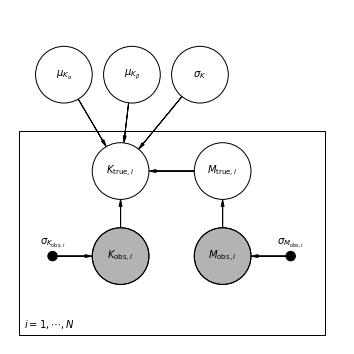

In [2]:
import daft
'''
No hyperpriors connect to M because, the true M values are takent obe found from the observaitonal data.
K has 3 variables in its hyperprior because they all are required to generate K values/priors
we don't know alpha and beta, so we need to constrain them.
'''

pgm = daft.PGM([3,3], grid_unit=4, node_unit=2)
#pgm = daft.PGM([4,3], grid_unit=5, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("K_mu_alpha_actual", r"$\mu_{K_{{\alpha}}}$", 0.5, 2.6))
pgm.add_node(daft.Node("K_mu_beta_actual", r"$\mu_{K_{{\beta}}}$", 1.1, 2.6))
pgm.add_node(daft.Node("K_sigma_actual", r"$\sigma_{K}$", 1.7, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("K_true", r"$K_{{\rm true},i}$", 1, 1.75))
pgm.add_node(daft.Node("M_true", r"$M_{{\rm true},i}$", 1.9, 1.75))
# Data.
pgm.add_node(daft.Node("K_obs", r"$K_{{\rm obs},i}$", 1, 1, observed=True))
pgm.add_node(daft.Node("Kerr", r"$\sigma_{K_{{\rm obs},i}}$", 0.4, 1.0, fixed=True, offset=[0.0,0.4]))
#pgm.add_node(daft.Node("Kerr", r"$\sigma_{K_{{\rm obs},i}}$", 0, 1.0, fixed=True, offset=[0.0,0.4]))
pgm.add_node(daft.Node("M_obs", r"$M_{{\rm obs},i}$", 1.9, 1, observed=True))
pgm.add_node(daft.Node("Merr", r"$\sigma_{M_{{\rm obs},i}}$", 2.5, 1.0, fixed=True, offset=[0.0,0.4]))
#pgm.add_node(daft.Node("Merr", r"$\sigma_{M_{{\rm obs},i}}$", 2.9, 1.0, fixed=True, offset=[0.0,0.4]))

# Add in the edges.
pgm.add_edge("K_mu_alpha_actual", "K_true")
pgm.add_edge("K_mu_beta_actual", "K_true")
pgm.add_edge("K_sigma_actual", "K_true")
pgm.add_edge("M_true", 'K_true')
pgm.add_edge("M_obs", "M_true")
pgm.add_edge("Merr", "M_obs")
pgm.add_edge("K_obs", "K_true")
pgm.add_edge("Kerr", "K_obs")
# And a plate.
pgm.add_plate(daft.Plate([0.1, 0.4, 2.7, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

In [ ]:
#CREATING THE MODEL##########################################################################################
#mu_guess = -1.61 #estimation of actual_mu 
#dmu_guess = 0.1 #error of mu_guess, needs to be magnitudes larger than mu_guess, unless we have some idea of what mu and the spread is.
K_mu_alpha_guess = -1.61
del_K_mu_alpha_guess = 0.5
K_mu_beta_guess = 0
del_K_mu_beta_guess = 10

K_sigma_guess = np.log10(0.03)
del_K_sigma_guess = 0.5

model=pm.Model()
with model:
    #how mu and sigma should be distributed, together i believe they are the priors
    #mu=pm.Normal('mu',mu_guess,dmu_guess)
    #sigma=pm.HalfNormal('sigma',dsigma)
    K_mu_alpha = pm.Normal('K_mu_alpha',K_mu_alpha_guess,del_K_mu_alpha_guess)
    K_mu_beta = pm.Normal('K_mu_beta',K_mu_beta_guess,del_K_mu_beta_guess)
    K_sigma = pm.Lognormal('K_sigma',K_sigma_guess,del_K_sigma_guess)
    
    Ktrue = pm.Normal('Ktrue', mu = (K_mu_alpha + (M_true - 1)*K_mu_beta), sigma = K_sigma, shape=N) #creates simulated populations from the priors
    Kobs = pm.Normal('Kobs', Ktrue, K_sigma_obs, observed=K_obs) #I think its used to create the posterior by comparing with the 'actual' data, x_obs.
    
    Mtrue = pm.Normal('Mtrue', mu = M_mu_actual, sigma = M_sigma_actual, shape=N)
    Mobs = pm.Normal('Mobs', Mtrue, M_sigma_obs, observed=M_obs)
    #shape=N, ensures the simulated populations formt he priors, has the same no. stars as the 'actual' data.
    #observed=x_obs, tells it to compare with the 'actual' data to create a posterior.
###########################################################################################

#Sampling##########################################################################################
with model:
    trace = pm.sample(tune=10000, target_accept=0.99) #defaults to NUTS sampler
    #tune = Number of iterations to tune, defaults to 500
    #target_accept = float in [0, 1]. The step size is tuned such that we approximate this acceptance rate. Higher values like 0.9 or 0.95 often work better for problematic posteriors.
###########################################################################################

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Mtrue, Ktrue, K_sigma, K_mu_beta, K_mu_alpha]
Sampling 4 chains:   7%|███▊                                                  | 2949/42000 [00:26<02:35, 251.48draws/s]

In [27]:
#Results##########################################################################################
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
K_mu_alpha,-1.612080,0.003259,0.000129,-1.618187,-1.605731,485.947393,1.001219
K_mu_beta,0.249205,0.035827,0.001715,0.181189,0.321878,405.852283,1.010218
Ktrue__0,-1.588017,0.039573,0.000895,-1.661999,-1.505560,2147.731586,1.000178
Ktrue__1,-1.589712,0.038776,0.000590,-1.667366,-1.518048,4198.190382,0.999112
Ktrue__2,-1.650442,0.039821,0.000766,-1.726194,-1.573074,2985.623617,1.000310
Ktrue__3,-1.607082,0.039480,0.000738,-1.679088,-1.526772,3036.079872,0.999304
Ktrue__4,-1.602124,0.038757,0.000667,-1.674585,-1.521495,4214.416789,0.999627
Ktrue__5,-1.635670,0.039857,0.000944,-1.713025,-1.557648,1618.688618,1.001544
Ktrue__6,-1.589445,0.039757,0.000869,-1.663898,-1.509267,2333.975564,1.000269
Ktrue__7,-1.600910,0.040049,0.000714,-1.682497,-1.523948,3461.172367,0.999906


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F3FFC1BB70>,
      dtype=object)

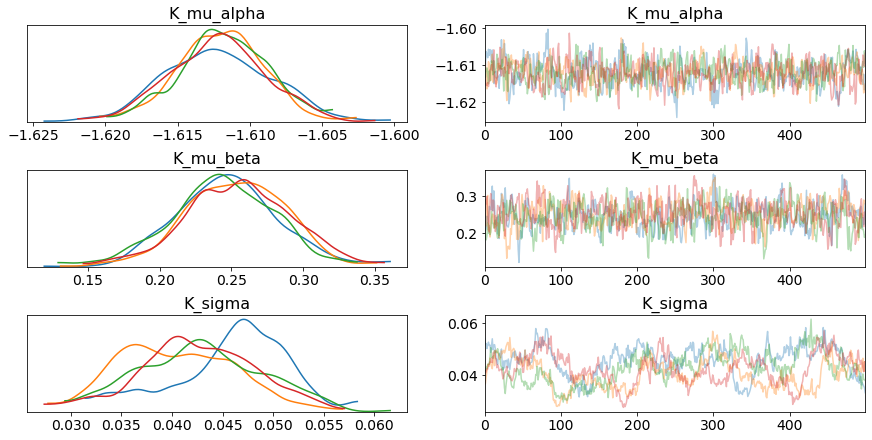

In [28]:
pm.plots.traceplot(trace,var_names=['K_mu_alpha','K_mu_beta','K_sigma'])
###########################################################################################

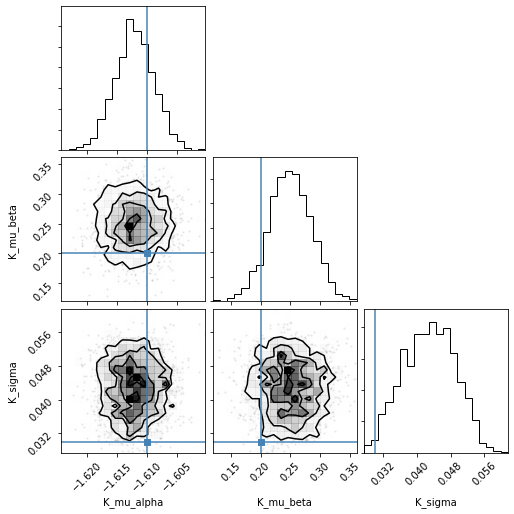

In [29]:
#print(trace.__dict__)
#print(trace.__dict__.keys())
#print(dir(trace))
#trace.varnames = ['K_mu_alpha', 'K_mu_beta', 'K_sigma_log__', 'Ktrue', 'K_sigma']
#trace.stat_names = {'depth', 'diverging', 'energy','energy_error','max_energy_error','mean_tree_accept','model_logp','step_size','step_size_bar','tree_size','tune'}trace['K_mu_alpha']

#'''
import corner
data = np.vstack([trace['K_mu_alpha'], trace['K_mu_beta'], trace['K_sigma']]).T
corner.corner(data, labels=['K_mu_alpha', 'K_mu_beta', 'K_sigma'], truths=[K_mu_alpha_actual, K_mu_beta_actual, K_sigma_actual])
plt.show()
#'''